In [70]:
import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

In [103]:
class SVM:
    def __init__(self, C=2, kernel='rbf', gamma=0.1, degree=1):
        print('Kernel:', kernel)
        if kernel == 'poly':
            self.gamma = gamma
            self.d = degree
            kernel = self._polynomial_kernel_batch
        elif kernel == 'sigmoid':
            self.gamma = gamma
            kernel = self._sigmoid_kernel_batch
        else:
            self.gamma = gamma
            kernel = self._rbf_kernel_batch
            
        self.C = C
        self.c = 1
        self.kernel = kernel
        self.X = None
        self.y = None
        self.n = None
        self.m = None
        self.lamda = None
        self.b = None
        self.ones = None
    def _polynomial_kernel(self, X1, X2):
        return (self.c + X1 @ X2.T) ** self.d
    def _sigmoid_kernel(self, X1, X2):
        return np.tanh(self.c + self.gamma * (X1 @ X2.T))
    def _rbf_kernel(self, X1, X2):
        return np.exp((-np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2)**2) / (2 * self.gamma**2))
    # use for large scale dataset
    def _polynomial_kernel_batch(self, X1, X2, batch_size=100):
        results = []
        for i in range(0, X1.shape[0], batch_size):
            X1_batch = X1[i:i + batch_size]
            batch_result = (self.c + X1_batch @ X2.T) ** self.d
            results.append(batch_result)
        return np.vstack(results)
    def _sigmoid_kernel_batch(self, X1, X2, batch_size=100):
        results = []
        for i in range(0, X1.shape[0], batch_size):
            X1_batch = X1[i:i + batch_size]
            batch_result = np.tanh(self.c + self.gamma * (X1_batch @ X2.T))
            results.append(batch_result)
        return np.vstack(results)
    def _rbf_kernel_batch(self, X1, X2, batch_size=100):
        results = []
        for i in range(0, X1.shape[0], batch_size):
            X1_batch = X1[i:i + batch_size]
            batch_result = np.exp((-np.linalg.norm(X1_batch[:, np.newaxis] - X2[np.newaxis, :], axis=2)**2) / (2 * self.gamma**2))
            results.append(batch_result)
        return np.vstack(results)
    
    def cost(self, kernel_matrix):
        return np.sum(self.lamda) - 0.5 * np.sum(np.outer(self.lamda, self.lamda) * kernel_matrix)
    def fit(self, X, y, schedule='step' ,lr=1e-3, epochs=1000, decay_rate=0.9, show_loss=False):
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.m = X.shape[1]
        self.lamda = np.random.random(X.shape[0])
        self.b = 0
        self.ones = np.ones(X.shape[0])
        
        kernel_matrix = np.outer(y,y) * self.kernel(X, X)
        cost_values = []
       
        for epoch in range (epochs):
            # maximize L(lamda)

            grad = self.ones - kernel_matrix @ self.lamda
            self.lamda += lr * grad
            self.lamda = np.clip(self.lamda, 0, self.C)

            cost = np.sum(self.lamda) - 0.5 * np.sum(np.outer(self.lamda, self.lamda) * kernel_matrix)
            # cost = self.cost(kernel_batch)
            if (len(cost_values) > 1) and (np.abs(cost_values[-1] - cost_values[-2]) < 1e-4):
                print('Coverage at ite:', epoch)
                break
            cost_values.append(cost)

            lr *= decay_rate
            
        support_vectors = np.where((self.lamda > 0) & (self.lamda < self.C))[0]
        if len(support_vectors) > 0:
            self.b = np.mean(y[support_vectors] - ((self.lamda * y) @ self.kernel(X, X[support_vectors])))
        else:
            print("No support vectors found.")
            self.b = 0
        if show_loss:
            plt.plot(cost_values)
            plt.title('Loss per epoch')
            plt.show()
    def decision_function(self, X):
        return ((self.lamda * self.y) @ self.kernel(self.X, X)) + self.b
    def predict(self, X):
        return np.sign(self.decision_function(X))
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)
    def visualize(self):
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, s=50, cmap='autumn', alpha=.5)
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T 
        Z = self.decision_function(xy).reshape(XX.shape)
        
        ax.contour(XX, YY, Z, colors=['b', 'g', 'r'], levels=[-1, 0, 1], alpha=0.5, 
                   linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])
        # ax.scatter(self.X[:, 0][self.lamda > 0.], self.X[:, 1][self.lamda > 0.], s=50,
        #            linewidth=1, facecolors='none', edgecolors='k')
        plt.show()

### Circle Dataset

Kernel: poly
Coverage at ite: 178


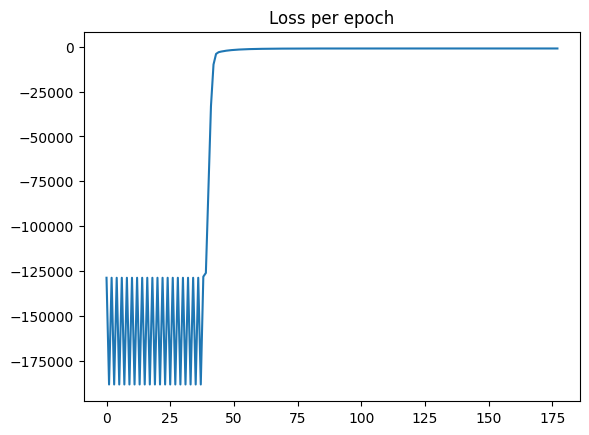

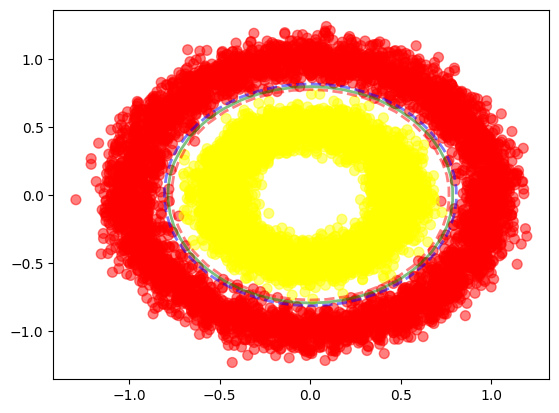

0.9981


In [82]:
from sklearn.datasets import make_circles
X, y = make_circles(10000, factor=.5, noise=.08, random_state=42)
y[y ==0 ] = -1
svm = SVM(C=0.1, kernel='poly', gamma=0.1, degree=2)
svm.fit(X, y, lr = 0.01, epochs=500)
svm.visualize()
print(svm.score(X, y))

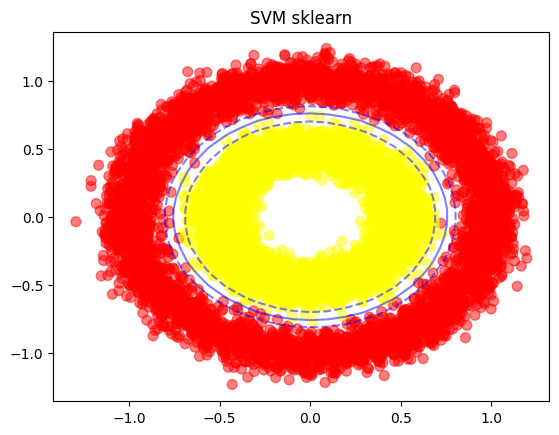

Độ chính xác sklearn: 0.9996


In [78]:
from sklearn.svm import SVC
# SVM scikit-learn
classifier = SVC(kernel='poly', C=1, degree=4)
classifier.fit(X, y)

# Đồ thị sklearn
plt.figure()
plt.title("SVM sklearn")
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', alpha=0.5)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = classifier.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='b', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
plt.show()

# Độ chính xác sklearn
print("Độ chính xác sklearn:", classifier.score(X, y))

### Moon Dataset

Kernel: rbf
Coverage at ite: 117


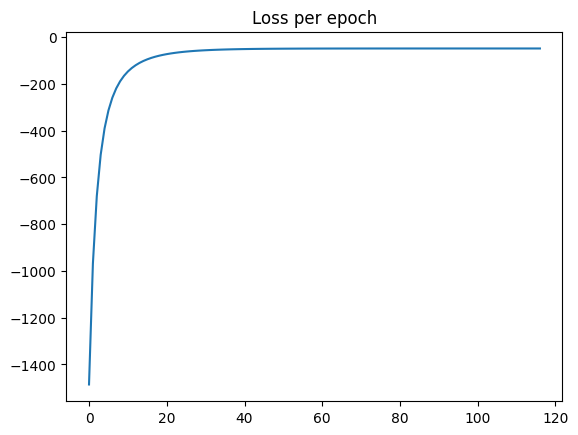

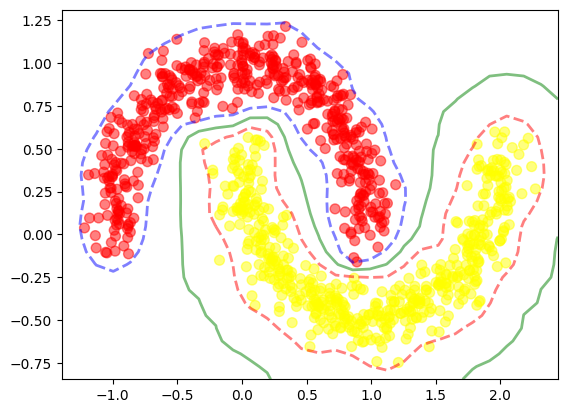

1.0


In [84]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
y[y == 0] = -1
svm = SVM(C=1, kernel='rbf',gamma=0.1)
svm.fit(X, y, lr=0.01)
svm.visualize()
print(svm.score(X, y))


### Random Noise Dataset

Kernel: rbf
Coverage at ite: 98


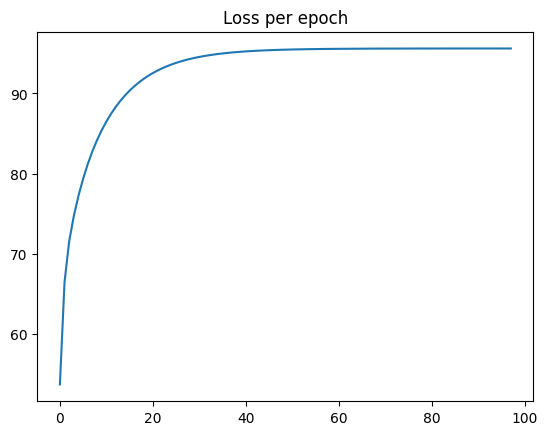

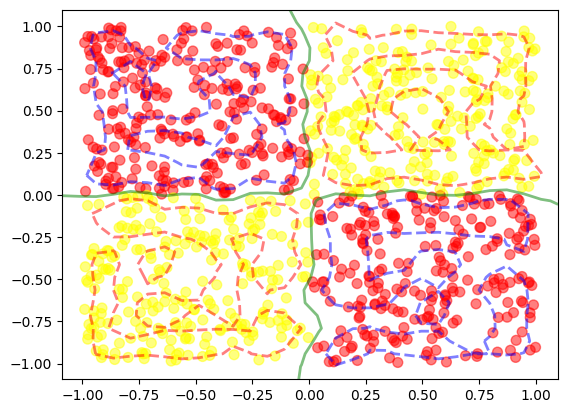

np.float64(0.999)

In [87]:
import numpy as np

np.random.seed(42)
X = np.random.rand(1000, 2) * 2 - 1 
y = np.sign(X[:, 0] * X[:, 1])  

svm = SVM(C=10 ,kernel='rbf', gamma=0.1, degree=2)
svm.fit(X, y, lr=0.1)
svm.visualize()
svm.score(X, y)


Kernel: rbf
Coverage at ite: 102


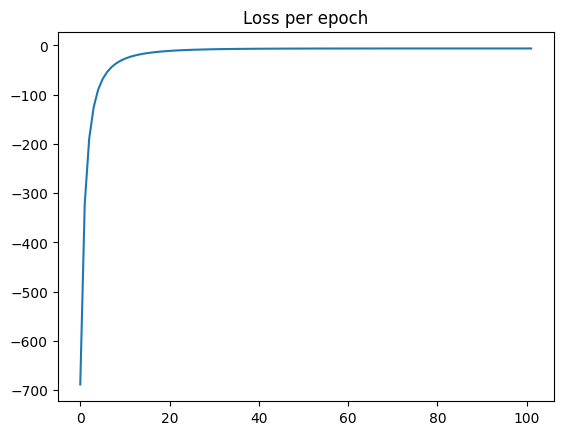

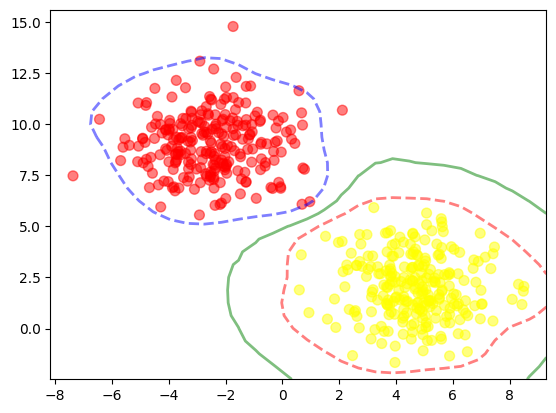

np.float64(1.0)

In [89]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=500, centers=2, random_state=42, cluster_std=1.5)
y[y == 0] = -1
svm = SVM(C=1 ,kernel='rbf',gamma=1, degree=1)
svm.fit(X, y, lr=0.01)
svm.visualize()
svm.score(X, y)


### Iris Dataset With Two Labels

In [101]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[iris.target != 2, :2]  # Chọn 2 lớp đầu tiên, 2 đặc trưng đầu tiên
y = iris.target[iris.target != 2]
y[y == 0] = -1
gammas = [0.001, 0.01, 0.1, 1, 2, 4, 16]
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]
results = []
for gamma in gammas:
    for learning_rate in learning_rates:
        svm = SVM(C=0.1, kernel='rbf', gamma=gamma)
        svm.fit(X, y, lr=learning_rate)
        results.append(((gamma, learning_rate), svm.score(X, y)))
results.sort(key=lambda x:x[1], reverse=True)
# svm.visualize()
best_params, best_score = results[0]

print(f"Best gamma: {best_params[0]}, Best learning rate: {best_params[1]}, Best score: {best_score}")


Kernel: rbf
Coverage at ite: 21
Kernel: rbf
Coverage at ite: 42
Kernel: rbf
Coverage at ite: 48
Kernel: rbf
Coverage at ite: 3
No support vectors found.
Kernel: rbf
Coverage at ite: 3
No support vectors found.
Kernel: rbf
Coverage at ite: 20
Kernel: rbf
Coverage at ite: 43
Kernel: rbf
Coverage at ite: 48
Kernel: rbf
Coverage at ite: 3
No support vectors found.
Kernel: rbf
Coverage at ite: 3
No support vectors found.
Kernel: rbf
Coverage at ite: 15
Kernel: rbf
Coverage at ite: 40
Kernel: rbf
Coverage at ite: 50
Kernel: rbf
Coverage at ite: 5
No support vectors found.
Kernel: rbf
Coverage at ite: 3
No support vectors found.
Kernel: rbf
Coverage at ite: 40
Kernel: rbf
Coverage at ite: 58
Kernel: rbf
Coverage at ite: 58
Kernel: rbf
Coverage at ite: 56
Kernel: rbf
Coverage at ite: 79
Kernel: rbf
Coverage at ite: 16
Kernel: rbf
Coverage at ite: 33
Kernel: rbf
Coverage at ite: 31
Kernel: rbf
Coverage at ite: 24
Kernel: rbf
Coverage at ite: 70
Kernel: rbf
Coverage at ite: 20
Kernel: rbf
Covera

Kernel: rbf
Coverage at ite: 17
No support vectors found.


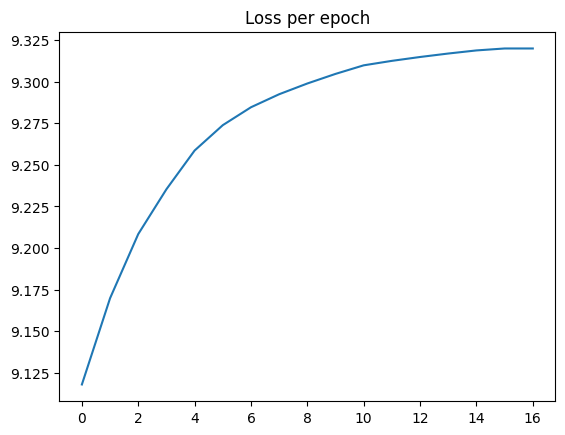

np.float64(1.0)

In [105]:
svm = SVM(C=0.1, kernel='rbf', gamma=best_params[0])
svm.fit(X, y, lr=best_params[1], show_loss=True)
svm.score(X, y)